# Практическая работа №2 по вычислительной математике
## Бабушкина Татьяна

### Объявление функций и подключение библиотек

In [80]:
%matplotlib inline

import numpy as np
import math
from matplotlib import pylab as plt

In [81]:
# Создание сетки:
def make_grid(n):
    h = L / (n-1)
    x = np.linspace(start = 0, stop = L, num = n, dtype = float)
    if len(x) != n:
        print('Ошибка с построением сетки, попробуйте выбрать другое n')
        return None
    return x, h

In [82]:
# Определение функций

def q(x):
    if x.__class__ == float:
        if x < x0:
            return 1
        else:
            return np.exp(-x**2)
    ret = np.full(len(x), 1.)
    for i in range(len(ret)):
        if x[i] > x0:
            ret[i] = np.exp(-x[i]**2)
    return ret

def f(x):
    if x.__class__ == float:
        if x < x0:
            return 1.
        else:
            return np.cos(x)
    ret = np.full(len(x), 1.)
    for i in range(len(ret)):
        if x[i] > x0:
            ret[i] = np.cos(x[i])
    return ret

def k(x):
    return x**2 + 0.5

In [83]:
def solve(n):
    x, h = make_grid(n+1)
    A = [0 for i in range(n)]
    B = [0 for i in range(n)]
    A[1] = k_ar[1] / (k_ar[0] + k_ar[1])
    B[1] = (k_ar[0] + (f_ar[0] - q_ar[0])*h*h) / (k_ar[0] + k_ar[1])
    for i in range(1, n-1):
        A[i+1] = k_ar[i+1] / (k_ar[i+1] + k_ar[i]*(1 - A[i]) + q_ar[i]*A[i]*h*h)
        B[i+1] = ((k_ar[i] - q_ar[i]*h*h)*B[i] + f_ar[i]*h*h) / (k_ar[i+1] + k_ar[i]*(1-A[i]) + q_ar[i]*A[i]*h*h)
    ret = np.zeros(n+1)
    ret[n] = 0.
    ret[0] = 1.
    for i in range(n-1, 0, -1):
        ret[i] = A[i] * ret[i+1] + B[i]
    return ret

# Решение
## Модельная задача
Здесь по условию $x_0 = 1/\sqrt3$. Обозначим $K = k(x_0)$, $Q = q(x_0)$, $F = f(x_0)$. Нетрудно проверить, что все коэффициенты больше нуля.

Уравнение принимает такой вид:
$$
K\frac{d^2u}{dx^2} - Qu = -F
$$

Обозначим $\alpha = \sqrt{Q/K}$. Тогда общее решение этого уравнения:
$$
u(x) = \frac FQ + C_1 e^{-\alpha x} + C_2 e^{\alpha x}
$$

С учётом краевых условий $u(0) = u(1) = 1$:
$$
C_1 = \frac{(Q-F)e^{\alpha}}{Q\left(e^{\alpha} + 1\right)};\qquad
C_2 = \frac{(Q-F)}{Q\left(e^{\alpha} + 1\right)}
$$

u_modan


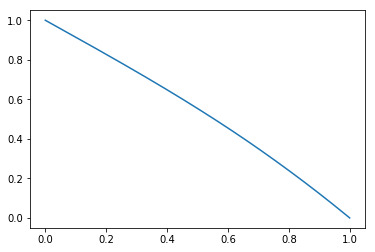

In [139]:
n = 1000000

L = 1. # правый конец отрезка

# параметры решения
x0 = 1./math.sqrt(2)
K0 = k(x0)
K1 = k(x0)
Q0 = 1.
Q1 = math.exp(-x0**2)
F0 = 1.
F1 = math.cos(x0)





alpha0 = np.sqrt(Q0/K0)
alpha1 = np.sqrt(Q1/K1)

Mat = np.array([[1., 1., 0., 0.],
               [np.exp(-alpha0*x0), np.exp(alpha0*x0), -np.exp(-alpha1*x0), -np.exp(alpha1*x0)],
               [-np.exp(-alpha0*x0), np.exp(alpha0*x0),
                K1*alpha1/(K0*alpha0)*np.exp(-alpha1*x0), -K1*alpha1/(K0*alpha0)*np.exp(alpha1*x0)],
               [0., 0., 1, np.exp(2*alpha1)]])

vec = np.array([1. - F0/Q0, F1/Q1 - F0/Q0, 0., -np.exp(alpha1)*F1/Q1])

C = np.dot(np.linalg.inv(Mat), vec)

x, h = make_grid(n+1)

umod_an = np.zeros(len(x))
for i in range(len(x)):
    if x[i] < x0:
        umod_an[i] = F0/Q0 + C[0]*np.exp(-alpha0 * x[i]) + C[1]*np.exp(alpha0 * x[i])
    else:
        umod_an[i] = F1/Q1 + C[2]*np.exp(-alpha1 * x[i]) + C[3]*np.exp(alpha1 * x[i])

plt.plot(x, umod_an)
print('u_modan')
plt.show()

## Численное решение модельной задачи

Для численного решения используем метод встречных прогонок.

Приближаем дифференциальное уравнение разностным:
$$
\frac{k_{n+1}\cfrac{u_{n+2} - u_{n+1}}{h} - k_n\cfrac{u_{n+1} - u_n}{h}}{h} - q_nu_n = -f_n, \qquad n = \overline{0, N-2}
$$

Краевые условия: $u_0 = u_N = 1$.

Ищем решение в виде следующей рекурренты:
$$
u_n = A_nu_{n+1} + B_n, \qquad n = \overline{1, N-1}
$$

Решаем и получаем следующие рекуррентные формулы на $A_n$, $B_n$:
$$
A_{n+1} = \frac{k_{n+1}}{k_{n+1} + k_n(1-A_n) + q_nA_nh^2}; \qquad
B_{n+1} = \frac{(k_n-q_nh^2)B_n + f_nh^2}{k_{n+1} + k_n(1-A_n) + q_nA_nh^2}
$$

$$
A_1 = \frac{k_1}{k_0+k_1}; \qquad
B_1 = \frac{k_0 + (f_0 - q_0)h^2}{k_0+k_1}
$$

umod_num


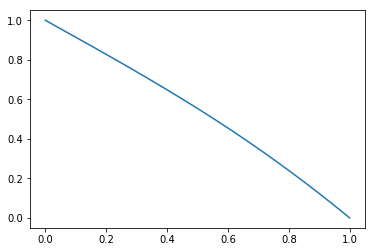

2.3546595163681516e-06


In [140]:
# Численное решение модельной задачи

x, h = make_grid(n+1)
q_ar = np.zeros(n+1)
f_ar = np.zeros(n+1)
k_ar = np.zeros(n+1)
for i in range(n+1):
    if x[i] < x0:
        k_ar[i] = K0
        q_ar[i] = Q0
        f_ar[i] = F0
    else:
        k_ar[i] = K1
        q_ar[i] = Q1
        f_ar[i] = F1
umod_num = solve(n)


plt.plot(x, umod_num)
print('umod_num')
plt.show()

delta = max(abs(umod_num - umod_an))
print(delta)

In [141]:
# параметры основной задачи
L = 1.   # правый конец отрезка
x0 = 1./np.sqrt(2)

u_num


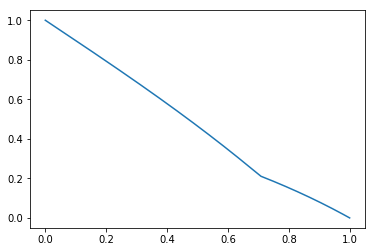

In [142]:
# численное решение основной задачи

x, h = make_grid(n+1)
k_ar = np.exp(np.cos(x))
for i in range(len(k_ar)):
    if (x[i] < x0):
        k_ar[i] = 1.
q_ar = q(x)
f_ar = f(x)
u_num = solve(n)
plt.plot(x, u_num)
print('u_num')
plt.show()

## Ответ

In [144]:
from IPython.display import HTML, display
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})

x, h = make_grid(81921)

display(HTML("""
<html><body>
Аналитическое решение модельной задачи<br>""" + str(x) + "<br>" + str(umod_an[::len(umod_an)//10]) + "<br><br>" +
             "Численное решение модельной задачи<br>" + str(x) + "<br>" + str(umod_num[::len(umod_num)//10]) + "<br><br>" +
             "delta = " + str(delta) + "<br><br>" +
             "Численное решение задачи с переменными коэффициентами<br>" + str(x) + "<br>" +
             str(u_num[::len(u_num)//10]) + "<br>" + 
             """</body></html>"""))